In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from models import BasicUNet
from training_functions import train_unet
from helper_functions import Evaluator, calculate_frechet_distance, generate_images_unet, evaluate_unet

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


## Wczytanie danych

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
dataset_path = "./trafic_32"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

labels = dataset.classes
print("Number of labels:", len(dataset.classes))

Number of labels: 43


In [3]:
train_ratio = 0.8

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train, val = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=True, num_workers=4)

## Podstawowy model

In [4]:
image_dim = 3*32*32
evaluator = Evaluator(image_dim, 256, n_classes=len(labels)).to(device)
evaluator.load_state_dict(torch.load("evaluator.pth"))

<All keys matched successfully>

In [5]:
net = BasicUNet(in_channels=3, out_channels=3).to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=0.001)

In [7]:
loss_hist = train_unet(net, train_loader, opt, loss_fn, epochs=10)

100%|██████████| 10/10 [05:21<00:00, 32.15s/it]


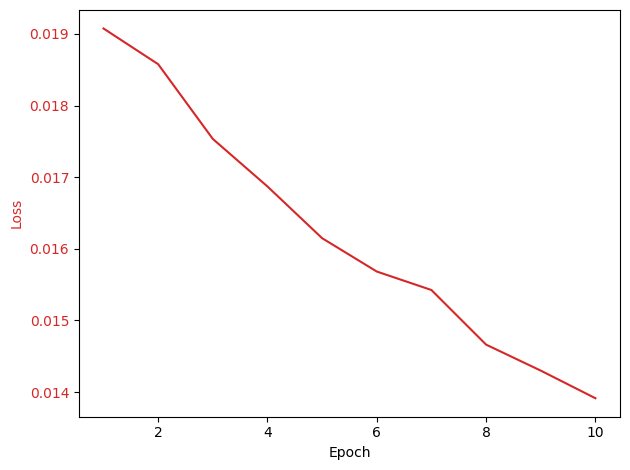

In [8]:
fig, ax1 = plt.subplots()
iters = np.arange(1, 11)
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(iters, loss_hist, color=color)
ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [10]:
val_loader = torch.utils.data.DataLoader(val, batch_size=len(val), shuffle=True, num_workers=4)
val_set = next(iter(val_loader))
ferchet_distance = evaluate_unet(evaluator, net, val_set[0], device)
print("Frechet distance:", ferchet_distance)

Frechet distance: 1149.7145161580893


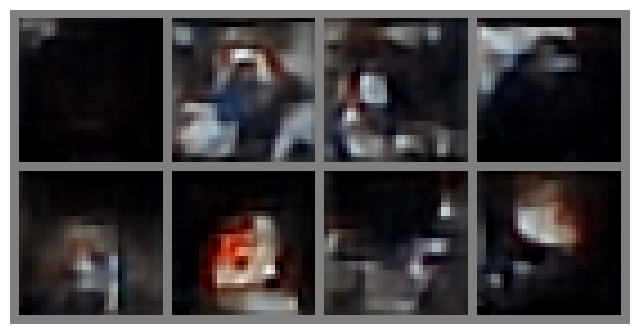

In [11]:
n_gen = 8 
generations, pred_hist, step_hist = generate_images_unet(net, n_gen)
imgs = generations.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()

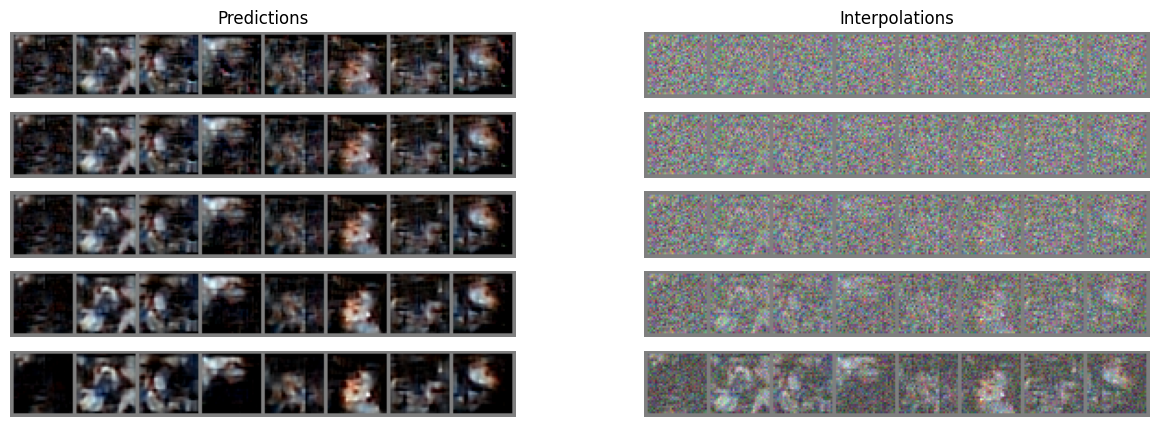

In [12]:
n = 5
fig, ax = plt.subplots(n, 2, figsize=(15, 5))
for i in range(n):
    ax[i, 0].imshow(torchvision.utils.make_grid(pred_hist[len(pred_hist) // n * i], normalize=True, pad_value=0.5).permute(1, 2, 0))
    ax[i, 0].axis('off')
    ax[i, 1].imshow(torchvision.utils.make_grid(step_hist[len(step_hist) // n * i], normalize=True, pad_value=0.5).permute(1, 2, 0))
    ax[i, 1].axis('off')
ax[0, 0].set_title('Predictions')
ax[0, 1].set_title('Interpolations')
plt.show()

## Większa struktura modelu

In [22]:
from models import LargeUNet

In [23]:
image_dim = 3*32*32
evaluator = Evaluator(image_dim, 256, n_classes=len(labels)).to(device)
evaluator.load_state_dict(torch.load("evaluator.pth"))

<All keys matched successfully>

In [24]:
net = LargeUNet(in_channels=3, out_channels=3, hidden_size=128, kernel_size=3, padding=1).to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=0.001)

In [25]:
loss_hist = train_unet(net, train_loader, opt, loss_fn, epochs=25)

100%|██████████| 25/25 [17:24<00:00, 41.80s/it]


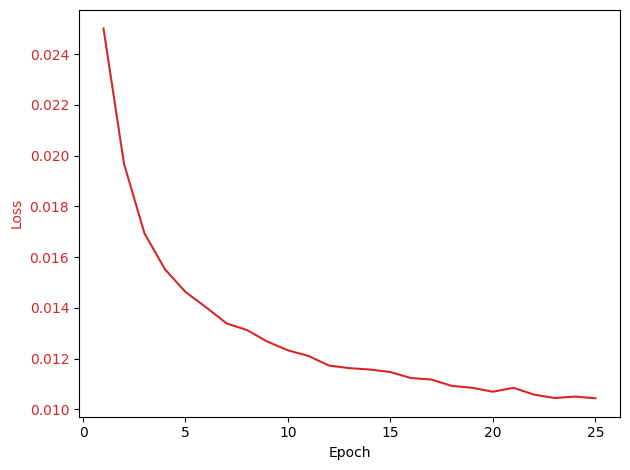

In [27]:
fig, ax1 = plt.subplots()
iters = np.arange(1, 26)
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(iters, loss_hist, color=color)
ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [28]:
val_loader = torch.utils.data.DataLoader(val, batch_size=len(val), shuffle=True, num_workers=4)
val_set = next(iter(val_loader))
ferchet_distance = evaluate_unet(evaluator, net, val_set[0], device)
print("Frechet distance:", ferchet_distance)

Frechet distance: 850.4863828703205


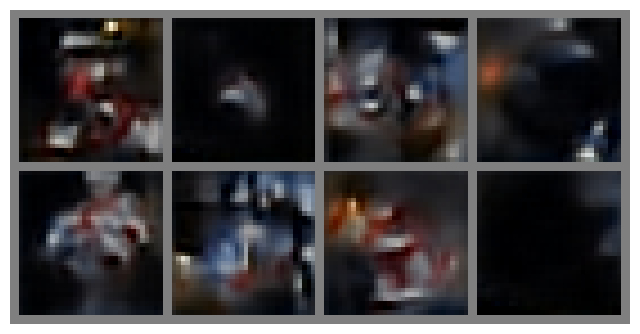

In [32]:
n_gen = 8 
generations, pred_hist, step_hist = generate_images_unet(net, n_gen)
imgs = generations.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()

## Warunkowanie klasą i czasem

In [13]:
from models import ConditionedLargeUNet
from training_functions import train_conditioned_unet

In [5]:
image_dim = 3*32*32
evaluator = Evaluator(image_dim, 256, n_classes=len(labels)).to(device)
evaluator.load_state_dict(torch.load("evaluator.pth"))

<All keys matched successfully>

In [6]:
net = ConditionedLargeUNet(in_channels=3, out_channels=3, hidden_size=128, kernel_size=3, padding=1, n_time_steps=50, n_classes=len(labels)).to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=0.001)

In [7]:
loss_hist = train_conditioned_unet(net, train_loader, opt, loss_fn, epochs=25, max_steps=50)

100%|██████████| 25/25 [23:31<00:00, 56.45s/it]


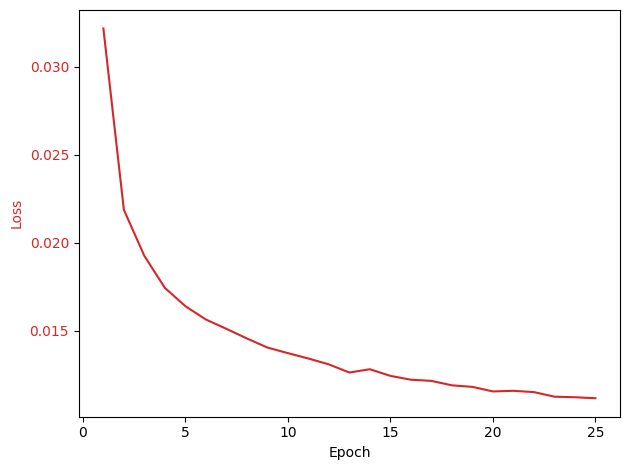

In [8]:
fig, ax1 = plt.subplots()
iters = np.arange(1, 26)
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(iters, loss_hist, color=color)
ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [4]:
def generate_images_c_unet(net, n_gen=32, n_steps=50, device='cuda'):
    pred_hist = []
    step_hist = []
    with torch.no_grad():
        fixed_noise = torch.randn(n_gen, 3, 32, 32).to(device)
        fixed_labels = torch.randint(0, len(labels), (n_gen,)).to(device)
        x = net(fixed_noise, torch.tensor([0] * n_gen).to(device), fixed_labels)
        for i in range(n_steps):
            step_hist.append(x.detach().cpu()) 
            i = torch.tensor([i] * n_gen).to(device)
            pred = net(x, i, fixed_labels)
            pred_hist.append(pred.detach().cpu())
            mix_factor = 1 / (n_steps - i)  
            x = x * (1 - mix_factor) + pred * mix_factor  
        return pred, pred_hist, step_hist
    
def evaluate_c_unet(eval, model, orig_data, device, n_gen=32, n_steps=50):
    with torch.no_grad():
        fixed_noise = torch.randn(n_gen, 3, 32, 32).to(device)
        fixed_labels = torch.randint(0, len(labels), (n_gen,)).to(device)
        x = model(fixed_noise, torch.tensor([0] * n_gen).to(device), fixed_labels)
        for i in range(n_steps):
            i = torch.tensor([i] * n_gen).to(device)
            pred = model(x, i, fixed_labels)
            mix_factor = 1 / (n_steps - i) 
            x = x * (1 - mix_factor) + pred * mix_factor  
        dist_orig_data = eval.get_features(orig_data.to(device)).cpu()
        dist_gen = eval.get_features(pred.to(device)).cpu()
        return calculate_frechet_distance(dist_orig_data.numpy(), dist_gen.numpy())

In [42]:
val_loader = torch.utils.data.DataLoader(val, batch_size=len(val), shuffle=True, num_workers=4)
val_set = next(iter(val_loader))
ferchet_distance = evaluate_c_unet(evaluator, net, val_set[0], device, n_gen=32, n_steps=50)
print("Frechet distance:", ferchet_distance)

Frechet distance: 1447.98816130237


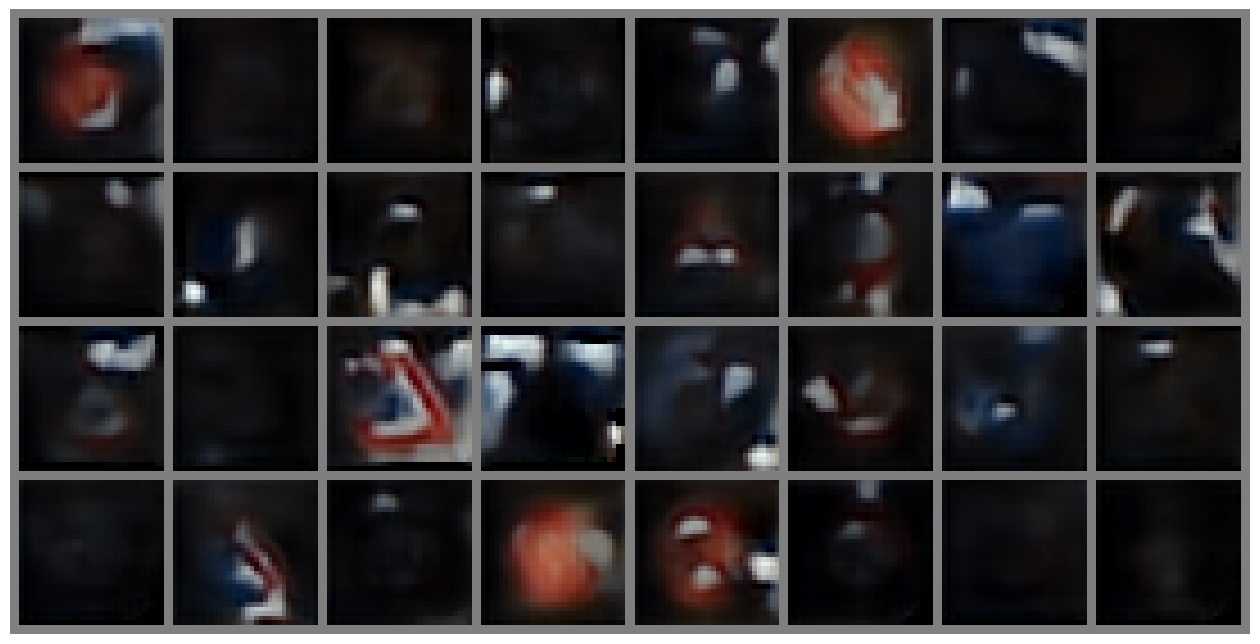

In [45]:
generations, pred_hist, step_hist = generate_images_c_unet(net)
imgs = generations.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(16, 10))
plt.imshow(grid)
plt.axis('off')
plt.show()

## Dobranie hiperparametrów

In [5]:
from models import ConditionedLargeUNet
from training_functions import train_conditioned_unet
import optuna

val_loader = torch.utils.data.DataLoader(val, batch_size=len(val), shuffle=True, num_workers=4)
val_set = next(iter(val_loader))

In [6]:
def define_model(trial):
    sizes = [(128, 3, 1), (256, 3, 1), (512, 3, 1), (128, 5, 2), (256, 5, 2), (512, 5, 2)]
    hidden_size, kernel_size, padding = sizes[trial.suggest_int('size', 0, 5)]
    n_time_steps = trial.suggest_int('n_time_steps', 50, 500)
    return ConditionedLargeUNet(in_channels=3, out_channels=3, hidden_size=hidden_size, kernel_size=kernel_size, padding=padding, n_time_steps=n_time_steps, n_classes=len(labels)).to(device), n_time_steps

def objective(trial):
    model, max_ts = define_model(trial)
    loss_fn = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=trial.suggest_float('learning_rate', 1e-4, 1e-2))
    train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=0)
    image_dim = 3*32*32
    evaluator = Evaluator(image_dim, 256, n_classes=len(labels)).to(device)
    evaluator.load_state_dict(torch.load("evaluator.pth"))
    try:
        _ = train_conditioned_unet(model, train_loader, opt, loss_fn, epochs=10, max_steps=max_ts, trial=trial, verbose=False)
    except Exception as e:
        return np.inf

    evals = []
    for _ in range(10):
        evals.append(evaluate_c_unet(evaluator, model, val_set[0], device, n_gen=32, n_steps=max_ts))
    return sum(evals)/len(evals)

In [7]:
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_startup_trials=5))
study.optimize(objective, n_trials=20, timeout=3600, n_jobs=-1)

best_params = study.best_params
for key, value in best_params.items():
    print(f"{key}: {value}")

[I 2024-05-12 19:53:42,938] A new study created in memory with name: no-name-305ec664-2139-4eb6-b421-7f7e38c9937a
[I 2024-05-12 20:35:10,239] Trial 6 finished with value: 2877.706667342113 and parameters: {'size': 1, 'n_time_steps': 83, 'learning_rate': 0.008195239066030544}. Best is trial 6 with value: 2877.706667342113.
[I 2024-05-12 20:45:30,670] Trial 8 finished with value: 1054.6311791445391 and parameters: {'size': 3, 'n_time_steps': 126, 'learning_rate': 0.0036419561239554848}. Best is trial 8 with value: 1054.6311791445391.
[I 2024-05-12 20:46:18,278] Trial 10 finished with value: 1198.0460791831597 and parameters: {'size': 4, 'n_time_steps': 126, 'learning_rate': 0.005757681065593308}. Best is trial 8 with value: 1054.6311791445391.
[I 2024-05-12 21:01:18,490] Trial 14 finished with value: 1097.9685994081765 and parameters: {'size': 1, 'n_time_steps': 187, 'learning_rate': 0.0028201394514739343}. Best is trial 8 with value: 1054.6311791445391.
[W 2024-05-12 21:16:16,247] Trial

size: 5
n_time_steps: 276
learning_rate: 0.002890235996590734


/tmp/ipykernel_96007/2496925414.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)
[W 2024-05-12 21:34:34,710] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2024-05-12 21:34:34,710] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-05-12 21:34:34,710] Trial 4 is omitted in visualization because its objective value is inf or nan.
[W 2024-05-12 21:34:34,711] Trial 11 is omitted in visualization because its objective value is inf or nan.
[W 2024-05-12 21:34:34,711] Trial 12 is omitted in visualization because its objective value is inf or nan.
[W 2024-05-12 21:34:34,713] Trial 13 is omitted in visualization because its objective value is inf or nan.
[W 2024-05-12 21:34:34,713] Trial 16 is omitted in visualization because its objective value is inf or nan.
[W 2024-05-12 

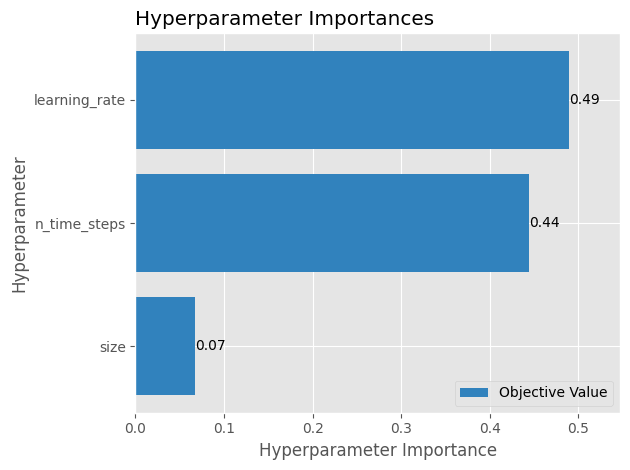

In [8]:
fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.tight_layout()
plt.show()

/tmp/ipykernel_96007/2297176039.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study)
[W 2024-05-12 21:34:57,720] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
[W 2024-05-12 21:34:57,721] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2024-05-12 21:34:57,721] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-05-12 21:34:57,722] Trial 4 is omitted in visualization because its objective value is inf or nan.
[W 2024-05-12 21:34:57,722] Trial 11 is omitted in visualization because its objective value is inf or nan.
[W 2024-05-12 21:34:57,722] Trial 12 is omitted in visualization because its objective value is inf or nan.
[W 2024-05-12 21:34:57,723] Trial 13 is omitted in visualization because its objective value

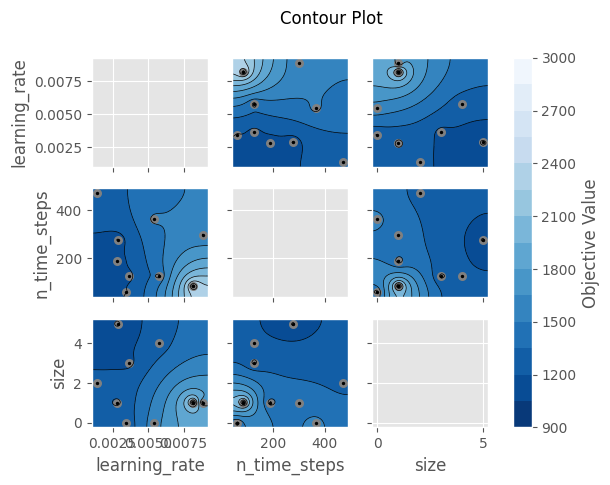

In [9]:
fig = optuna.visualization.matplotlib.plot_contour(study)
plt.show()

## Finałowy model

In [14]:
net = ConditionedLargeUNet(in_channels=3, out_channels=3, hidden_size=512, kernel_size=5, padding=2, n_classes=len(labels), n_time_steps=300).to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=0.002)
loss_hist = train_conditioned_unet(net, train_loader, opt, loss_fn, epochs=50, max_steps=300)
frechet_distance = evaluate_c_unet(evaluator, net, val_set[0], device, n_gen=32, n_steps=300)
print("Frechet distance:", frechet_distance)

 76%|███████▌  | 38/50 [2:44:25<51:55, 259.63s/it]  


KeyboardInterrupt: 

In [20]:
image_dim = 3*32*32
evaluator = Evaluator(image_dim, 256, n_classes=len(labels)).to(device)
evaluator.load_state_dict(torch.load("evaluator.pth"))
frechet_distance = evaluate_c_unet(evaluator, net, val_set[0], device, n_gen=32, n_steps=300)
print("Frechet distance:", frechet_distance)

Frechet distance: 1429.7862780819974


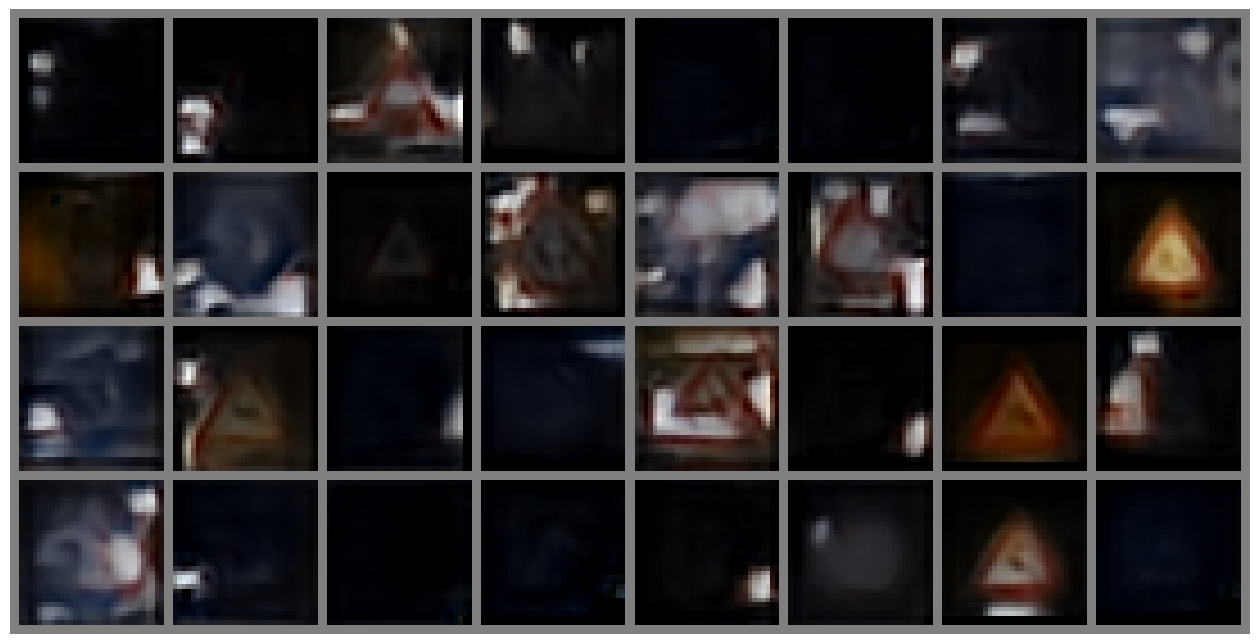

In [19]:
generations, pred_hist, step_hist = generate_images_c_unet(net, n_steps=300)
imgs = generations.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(16, 10))
plt.imshow(grid)
plt.axis('off')
plt.show()